# Reuters clustering

## Install intructions

- Setup tensorflow with anaconda (https://www.tensorflow.org/get_started/os_setup#anaconda_installation)
- `conda install beautifulsoup4 nltk jupyter matplotlib numpy scikit-learn`
- Put the reuters data in a folder called `data`
- `jupyter notebook`

In [1]:
# First read the data

from os import listdir
from os.path import isfile, join

from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize

def read_data(num=None, path='data', prefix='reut2-', tokenizer=word_tokenize):
    paths = [join(path, f) for f in listdir(path) if f.startswith(prefix)]

    for path in paths:
        with open(path, 'r') as f:
            soup = BeautifulSoup(f, 'html.parser')
            for article in soup.findAll('reuters'):
                if num is not None:
                    if num == 0:
                        raise StopIteration
                    num -= 1

                train = True if article['lewissplit'] == 'TRAIN' else False
                topics = map(lambda x: x.contents.pop(), article.findAll('d'))
                title = tokenizer(article.find('title').contents.pop()) if article.find('title') else []
                body = tokenizer(article.find('body').contents.pop()) if article.find('body') else []
                
                yield train, topics, title, body

14668 documents containing 73356 unique words and 406 unique topics
Document mean length: 133, std dev: 151
Most common words: the , . of to and said in a for mln The dlrs  's it on pct is < > from will that its be by Reuter at vs
Most common topics: usa earn acq uk canada japan money-fx grain crude west-germany trade interest france brazil ec wheat ship australia corn belgium ussr china switzerland money-supply netherlands dlr sugar oilseed coffee james-baker


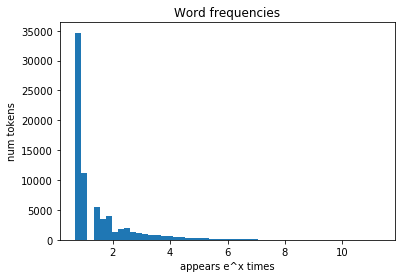

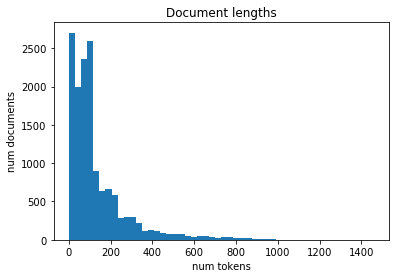

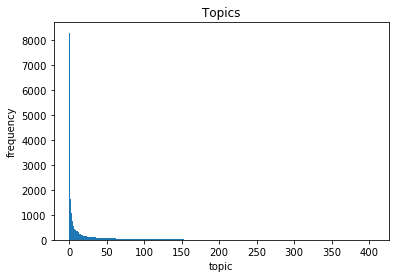

In [2]:
# Get familiar with the training set

import matplotlib.pyplot as plt

from collections import Counter

import numpy as np

def draw_hist(x, title, x_label=None, y_label=None, bin=True):
    if bin:
        hist, bins = np.histogram(x, bins=50)
    else:
        hist, bins = x, np.arange(len(x) + 1)
    _, ax = plt.subplots()
    ax.bar((bins[:-1] + bins[1:]) / 2, hist, width=(bins[1] - bins[0]))
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

tokens_c = Counter()
topics_c = Counter()
doc_length = []

for train, topics, title, body in read_data():
    if train:
        for token in title + body:
            tokens_c[token] += 1
        for topic in topics:
            topics_c[topic] += 1
        doc_length.append(len(body))

tokens, tok_freq = zip(*tokens_c.most_common())
topics, top_freq = zip(*topics_c.most_common())
token_index = {token: i for i, token in enumerate(['UNK'] + list(tokens))}
topic_index = {topic: i for i, topic in enumerate(['UNK'] + list(topics))}
num_topics = len(topic_index)

print('%d documents containing %d unique words and %d unique topics' % (len(doc_length), len(tokens), len(topics)))
print('Document mean length: %d, std dev: %d' % (np.mean(doc_length), np.std(doc_length)))
print('Most common words: %s' % ' '.join(tokens[:30]))
print('Most common topics: %s' % ' '.join(topics[:30]))

draw_hist(np.log(np.add(1, tok_freq)), 'Word frequencies', 'appears e^x times', 'num tokens')
draw_hist(doc_length, 'Document lengths', 'num tokens', 'num documents')
draw_hist(top_freq, 'Topics', 'topic', 'frequency', False)

plt.show()

Of particular interest we see that that the topics / classes are highly imbalanced. We also need to be aware of varying document lengths.

For measuring efficiency we'll use recall, fetching as many topics as there are target classes. While it is cheating not having to predict how many target classes there are per document, it easily lets us compare different models. All models will predict a distribution over classes, meaning the distribution can be evaluated with other precision / recall tradeoffs after the fact.

As baseline we'll simply predict the most common topics for every document. We will also do a tf-idf document embedding with logistic regression to get a feel for how hard the dataset is.

In [3]:
# Prepare train / test split

corpus, test_corpus = [], []
classes, test_classes = [], []

for train, topics, title, body in read_data():
    if not len(body):
            continue
    if train:
        corpus.append(body)
        classes.append(topics if len(topics) else ['UNK'])
    else:
        test_corpus.append(body)
        test_classes.append(topics if len(topics) else ['UNK'])

# indicator vectors for labels
labels = np.zeros((len(classes), num_topics))
indices = np.array([[col, topic_index[row]]
                    for col in range(len(classes))
                    for row in classes[col]])
labels[indices[:,0], indices[:,1]] = 1

test_labels = np.zeros((len(test_classes), num_topics))
indices = np.array([[col, topic_index.get(row, topic_index['UNK'])]
                    for col in range(len(test_classes))
                    for row in test_classes[col]])
test_labels[indices[:,0], indices[:,1]] = 1

In [4]:
# Calculate an absolute baseline (use globally most frequent topics as prediction)

words, _ = zip(*topics_c.most_common(20))
acc = 0.
for cs in test_classes:
    acc += len(set(words[:len(cs)]) & set(cs)) / float(len(cs))

print('Recall for topic frequency distribution is %f' % (acc / len(test_classes)))

Recall for topic frequency distribution is 0.543247


In [5]:
from sklearn import manifold
import matplotlib.pyplot as plt

def tsne(x, labels=None, title=None, num_points=3000):
    tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
    data = tsne.fit_transform(x[:num_points])
    x, y = zip(*data)
    _, ax = plt.subplots(figsize=(15, 10))
    ax.scatter(x, y)
    if labels:
        for i, (x, y) in enumerate(data):
            if i % (num_points / 100) == 0:
                ax.annotate(' '.join(labels[i]), (x, y))
    plt.title(title)
    plt.show()

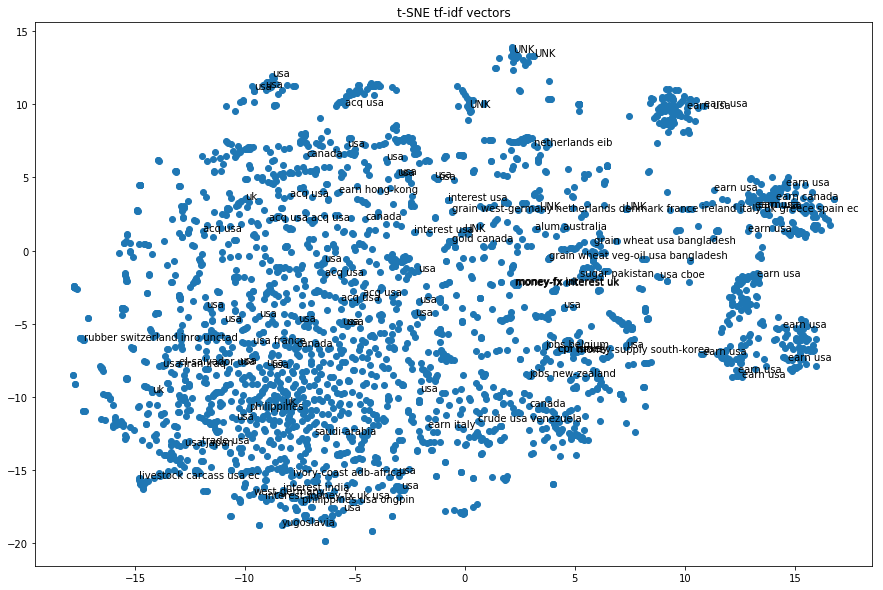

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

import tensorflow as tf

num_features = 1000

# More preprocessing (stemming, stopwords, etc) could probably improve tf-idf baseline
vectorizer = TfidfVectorizer(max_features=num_features)

data = vectorizer.fit_transform(np.asarray(map(' '.join, corpus))).toarray()

test_data = vectorizer.transform(np.asarray(map(' '.join, test_corpus))).toarray()

tsne(data, classes, 't-SNE tf-idf vectors')

We see some promising structure in the vector representations when reduced to two dimentions using t-SNE!

In [11]:
import tensorflow as tf
import matplotlib.pyplot as plt

def logreg(x, y):
    num_features = x.get_shape()[1]
    num_classes = y.get_shape()[1]
    
    freq = tf.reduce_sum(y, 0, keep_dims=True) # 1 x num_classes
    tot = tf.reduce_sum(freq)
    weights = tot / .99 * tf.reshape(tf.matmul(freq, y, transpose_b=True), [-1, 1]) # num_examples

    w = tf.get_variable('weights', (num_features, num_classes), initializer=tf.orthogonal_initializer())
    b = tf.get_variable('bias', (num_classes), initializer=tf.zeros_initializer)

    logits = tf.add(tf.matmul(x, w), b)
    y_hat = tf.nn.softmax(logits)
    cross_entropy = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits, y) * weights)
    
    loss = cross_entropy #+ 0.001 * (tf.nn.l2_loss(w) + tf.nn.l2_loss(b))

    global_step = tf.Variable(0, trainable=False)
    train_op = tf.train.AdamOptimizer().minimize(loss, global_step=global_step)

    return global_step, cross_entropy, y_hat, train_op   

def multilayer(x, y):
    num_features = x.get_shape()[1]
    num_classes = y.get_shape()[1]
    
    freq = tf.reduce_sum(y, 0, keep_dims=True) # 1 x num_classes
    tot = tf.reduce_sum(freq)
    weights = tot / .99 * tf.reshape(tf.matmul(freq, y, transpose_b=True), [-1, 1]) # num_examples x 1
    
    h = tf.get_variable('hidden_weights', (num_features, 50), initializer=tf.orthogonal_initializer())
    h_b = tf.get_variable('hidden_bias', (50), initializer=tf.zeros_initializer)
    
    hidden = tf.nn.relu(tf.add(tf.matmul(x, h), h_b))
    
    w = tf.get_variable('weights', (50, num_classes), initializer=tf.orthogonal_initializer())
    b = tf.get_variable('bias', (num_classes), initializer=tf.zeros_initializer)

    logits = tf.add(tf.matmul(hidden, w), b)
    y_hat = tf.nn.softmax(logits)
    cross_entropy = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits, y) * weights)
    
    loss = cross_entropy #+ 0.0001 * (tf.nn.l2_loss(w) + tf.nn.l2_loss(b) + tf.nn.l2_loss(h) + tf.nn.l2_loss(h_b))

    global_step = tf.Variable(0, trainable=False)
    train_op = tf.train.AdamOptimizer().minimize(loss, global_step=global_step)
    
    return global_step, cross_entropy, y_hat, train_op

def classify(model, train, test):
    x_train, y_train = train
    x_test, y_test = test
    
    num_features = x_train.shape[1]
    num_classes = y_train.shape[1]
    
    with tf.Graph().as_default():
        x = tf.placeholder(tf.float32, (None, num_features))
        y = tf.placeholder(tf.float32, (None, num_classes))
        
        global_step, cross_entropy, y_hat, train_op = model(x, y)

        with tf.Session() as sess:
            sess.run([tf.global_variables_initializer(),
                      tf.local_variables_initializer()])

            train_log, test_log, recall_log = [], [], []
            for _ in range(100):
                step, test_loss, pred = sess.run([global_step, cross_entropy, y_hat], feed_dict={
                    x: x_test,
                    y: y_test})
                p = np.argsort(pred)[:,:-20:-1]
                t = np.argsort(y_test)[:,:-20:-1]
                l = np.sum(y_test, 1)
                acc = 0.
                for i, (p_, t_, l_) in enumerate(zip(p,t,l)):
                    acc += len(set(p_[:int(l_)]) & set(t_[:int(l_)])) / l_
                test_log.append((step, test_loss))
                recall_log.append((step, acc / len(pred)))

                for i in range(50):
                    step, loss, _ = sess.run([global_step, cross_entropy, train_op], feed_dict={
                        x: x_train,
                        y: y_train})
                    train_log.append((step, loss))
                    #if i == 0:
                    #    print(test_loss, loss, acc / len(pred))

    x_train, y_train = zip(*train_log)
    x_test, y_test = zip(*test_log)
    x_rec, y_rec = zip(*recall_log)

    plt.plot(x_test, y_test, 'g', x_train, y_train, 'r')
    plt.xlabel('batch')
    plt.ylabel('cross entropy')
    plt.show()

    plt.plot(x_rec, y_rec, 'g')
    plt.xlabel('batch')
    plt.ylabel('recall')
    plt.show()
    
    print('Best recall: %f' % max(y_rec))

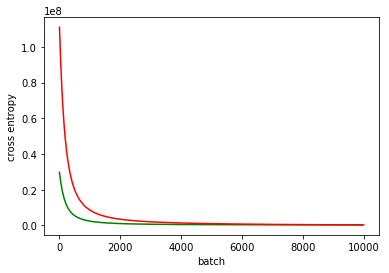

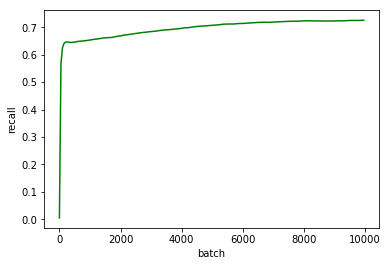

Best recall: 0.725457


In [12]:
classify(logreg, (data, labels), (test_data, test_labels))

Even with poor preprocessing / tokenization we get some improvement. Stemming, stopwords, etc would probably help. Also, I suspect the titles contain much better information while we're just looking at the body now.

However it's more fun to try and learn vector representations in an unsupervised manner - using paragraph2vec!

As thats quite heavy training we'll preprocess the data so that tensorflow graphs can read it directly.

In [ ]:
import tensorflow as tf
import random

def write(file_name='examples.tf'):
    def get_docs():
        # TODO: Cleaner test train merge
        docs = map(lambda x: (x, True), corpus) + map(lambda x: (x, False), test_corpus)
        cs = classes + test_classes
        for i in range(len(docs)):
            j = random.randint(0, len(docs) - 1)
            docs[i], docs[j] = docs[j], docs[i]
            cs[i], cs[j] = cs[j], cs[i]

        for i in range(len(docs)):
            d, train = docs[i]
            yield d, cs[i], train

    def get_pvdm(doc, index, window_size=8):
        '''CBOW with added document vector'''
        for i in range(len(doc)):
            if i + window_size > len(doc):
                continue
            words = [index.get(doc[j], index['UNK']) for j in range(i, i + window_size)]

            yield words
            
    def get_pvdm_example():
        for i, (doc, c, train) in enumerate(get_docs()):
            indices = map(lambda x: topic_index.get(x, topic_index['UNK']), c)
            for words in get_pvdm(doc, token_index):
                yield indices, i, words

    writer = tf.python_io.TFRecordWriter(file_name)

    for c, i, w in get_pvdm_example():
        example = tf.train.Example(features=tf.train.Features(feature={
                    'word': tf.train.Feature(int64_list=tf.train.Int64List(value=w)),
                    'topic': tf.train.Feature(int64_list=tf.train.Int64List(value=c)),
                    'document': tf.train.Feature(int64_list=tf.train.Int64List(value=[i]))}))
    writer.close()

def read_pvdm(epoch, batch, file_names=['p2v.tf']):
    filename_queue = tf.train.string_input_producer(
        file_names, num_epochs=epoch)

    reader = tf.TFRecordReader()
    _, serialized_example = reader.read(filename_queue)
    
    batch_examples = tf.train.shuffle_batch(
        [serialized_example],
        batch_size=batch,
        capacity=30000,
        num_threads=2,
        min_after_dequeue=1000,
        allow_smaller_final_batch=True)
    
    features = tf.parse_example(
    batch_examples,
    features={
        'word': tf.FixedLenFeature([8], tf.int64),
        'document': tf.FixedLenFeature([], tf.int64)})
    
    return features['word'], features['document']

# write('2k.tf')

In [ ]:
import tensorflow as tf

num_docs = len(corpus) + len(test_corpus)
num_words = len(tokens_c)
emb_size = 100
doc_emb_size = 200
neg_samples = 64
epochs = 100
batch = 512

with tf.Graph().as_default():
    word, document = read_pvdm(epochs, batch)
    
    words = tf.get_variable('word_weights', (num_words, emb_size), dtype=tf.float32)
    docs = tf.get_variable('doc_weights', (num_docs, doc_emb_size), dtype=tf.float32)
    
    word_emb = tf.nn.embedding_lookup(words, word[:,:-1]) # b x 7 x emb
    word_query = tf.reshape(word_emb, [-1, emb_size * 7])
    doc_emb = tf.nn.embedding_lookup(docs, document)

    U = tf.get_variable('u', (doc_emb_size + 7 * emb_size, emb_size))
    
    query = tf.concat(1, [doc_emb, word_query]) # b x (emb*8)

    res = tf.matmul(query, U)
    
    answ_i = word[:,-1:]
    
    L_sg = tf.reduce_sum(tf.nn.sampled_softmax_loss(
        tf.get_variable('target_weights', (num_words, emb_size), dtype=tf.float32),
        tf.get_variable('target_bias', (num_words), dtype=tf.float32),
        res,
        answ_i,
        neg_samples,
        num_words))
    
    global_step = tf.Variable(0, trainable=False)
    train_op = tf.train.AdamOptimizer().minimize(L_sg, global_step=global_step)
    
    saver = tf.train.Saver()
    with tf.Session() as sess:
        sess.run([tf.global_variables_initializer(),
                  tf.local_variables_initializer()])
        ckpt = tf.train.get_checkpoint_state('./pvdm-paragraph2vec3')
        if ckpt and ckpt.model_checkpoint_path:
            print('restoring ', ckpt.model_checkpoint_path)
            saver.restore(sess, ckpt.model_checkpoint_path)

        coord = tf.train.Coordinator()
        threads = tf.train.start_queue_runners(coord=coord)
        
        try:
            while not coord.should_stop():
                step, l_sg, _ = sess.run([global_step, L_sg, train_op])
                
                if step % 100000 == 0:
                    saver.save(sess, './pvdm-paragraph2vec3/paragraph2vec', global_step=step)

                if step % 1000 == 0:
                    print(step, l_sg)

        except tf.errors.OutOfRangeError:
            print('Done training!')
        finally:
            coord.request_stop()
        coord.join(threads)

('restoring ', u'./pvdm-paragraph2vec3/paragraph2vec-500000')


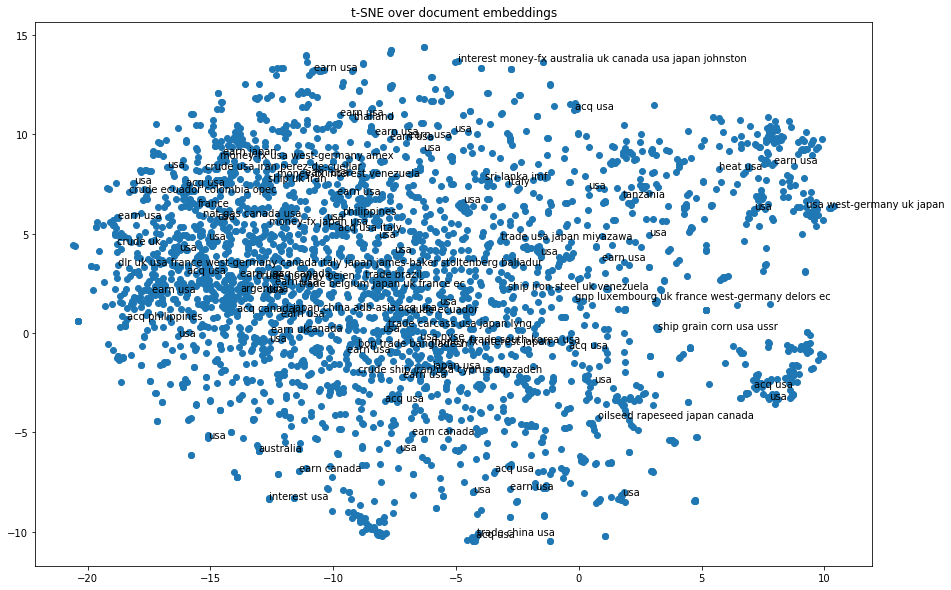

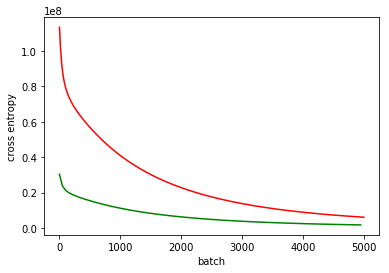

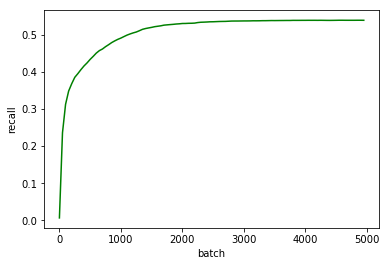

Best recall: 0.539081


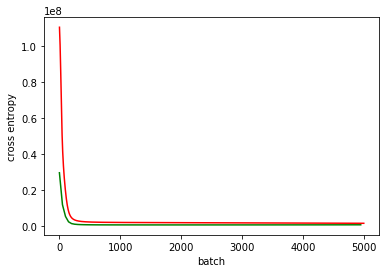

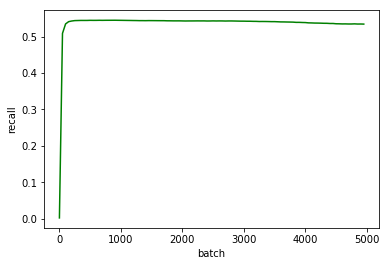

Best recall: 0.544803


In [9]:
import tensorflow as tf

num_docs = len(corpus) + len(test_corpus)
emb_size = 200

with tf.Graph().as_default():
    docs = tf.get_variable('doc_weights', (num_docs, emb_size), dtype=tf.float32)

    saver = tf.train.Saver([docs])
    with tf.Session() as sess:
        ckpt = tf.train.get_checkpoint_state('./pvdm-paragraph2vec3')
        if ckpt and ckpt.model_checkpoint_path:
            print('restoring ', ckpt.model_checkpoint_path)
            saver.restore(sess, ckpt.model_checkpoint_path)
        
        emb = sess.run(docs)

tsne(emb, test_classes, 't-SNE over document embeddings')
classify(logreg, (emb[:len(corpus)], labels),(emb[len(corpus):], test_labels))
classify(multilayer, (emb[:len(corpus)], labels),(emb[len(corpus):], test_labels))

In [10]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
pred = OneVsRestClassifier(LinearSVC(random_state=0)).fit(emb[:len(corpus)], labels).predict(emb[len(corpus):])

y = test_labels
c = np.sum(pred * y, 1) / np.sum(y, 1)
print(np.sum(c) / len(y))

/home/olav/anaconda2/envs/tensorflow/lib/python2.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 369 is present in all training examples.
  str(classes[c]))


0.438907471256


That didn't go quite as I hoped it would!

While there seems to be some structure in the t-SNE plot, using the embeddings as features doesn't seem to learn anything useful. I think we're simply learning the class frequencies. Adding an extra layer to the classifier hoping desperately there is some hidden meaning in the embeddings doesn't get us anywhere, nor does using an off the shelf SVM classifier.

For debugging this further I would start by properly reading the relevant paper and try to reproduce one of their results with their dataset. Also, working in jupyter notebook made me realise how dependent I am on graphing everything in tensorboard. I would migrate back there :)

The paragraph2vec approach was actually a subtask of a more ambitious model I was playing with originally. I attach the code without any results as of yet.

In [ ]:
# Train hybrid LDA/skipgram embeddings for documents and topics
# Inspired by http://multithreaded.stitchfix.com/blog/2016/05/27/lda2vec
# Enforcing supervised labels by masking topic membership distribution

import tensorflow as tf

num_topics = num_topics
num_docs = len(corpus) + len(test_corpus)
num_words = len(tokens_c)
emb_size = 100
neg_samples = 64
epochs = 100
batch = 256

dirichlet_w = 200

def masked_log_softmax(logits, axis, mask, name=None):
    with tf.name_scope(name, 'masked_log_softmax', [logits]):
        logits_exp = tf.exp(logits) * mask
        norm = tf.log(tf.reduce_sum(logits_exp, axis, keep_dims=True))
        log_softmax = (logits - norm) * mask
        
        return log_softmax

def masked_softmax(logits, axis, mask, epsilon=1e-12, name=None):
    with tf.name_scope(name, 'masked_softmax', [logits]):
        max_axis = tf.reduce_max(logits, axis, keep_dims=True)
        logits_exp = tf.exp(logits-max_axis) * mask
        norm = tf.reduce_sum(logits_exp, axis, keep_dims=True)
        softmax = logits_exp / (norm + epsilon)
        
        return softmax

with tf.Graph().as_default():
    word_i, ctx_i, doc_i, topic_mask, training_set = read(epochs, batch)
    
    topics = tf.get_variable('topic_weights', (num_topics, emb_size), dtype=tf.float32)
    docs = tf.get_variable('doc_weights', (num_docs, num_topics), dtype=tf.float32)
    words = tf.get_variable('word_weights', (num_words, emb_size), dtype=tf.float32)
    
    ctx = tf.nn.embedding_lookup(words, ctx_i)
    doc_logits = tf.nn.embedding_lookup(docs, doc_i)

    mask = tf.where(tf.cast(training_set, tf.bool), topic_mask, tf.ones_like(topic_mask))
    
    softmax = masked_softmax(doc_logits, 1, mask)
    doc = tf.matmul(softmax, topics)
    
    context = ctx + doc
    
    L_sg = tf.reduce_sum(tf.nn.nce_loss(
        tf.get_variable('target_weights', (num_words, emb_size), dtype=tf.float32),
        tf.get_variable('target_bias', (num_words), dtype=tf.float32),
        context,
        tf.expand_dims(word_i, -1),
        neg_samples,
        num_words))
    
    # maximizing Dirichlet likelihood as a regularizer!
    log_softmax = masked_log_softmax(doc_logits, 1, mask)
    alpha = 1 / tf.reduce_sum(mask, 1, keep_dims=True)
    L_d = -tf.reduce_sum(tf.log1p(tf.reduce_sum((alpha - 1) * log_softmax, 1)))
    
    loss = L_sg + dirichlet_w * L_d
    
    global_step = tf.Variable(0, trainable=False)
    train_op = tf.train.AdamOptimizer().minimize(loss, global_step=global_step)
    
    saver = tf.train.Saver()
    with tf.Session() as sess:
        sess.run([tf.global_variables_initializer(),
                  tf.local_variables_initializer()])
        ckpt = tf.train.get_checkpoint_state('./lda2vec')
        if ckpt and ckpt.model_checkpoint_path:
            print('restoring ', ckpt.model_checkpoint_path)
            saver.restore(sess, ckpt.model_checkpoint_path)

        coord = tf.train.Coordinator()
        threads = tf.train.start_queue_runners(coord=coord)
        
        try:
            while not coord.should_stop():
                step, l_sg, l_d, _ = sess.run([global_step, L_sg, L_d, train_op])
                
                if step % 1000 == 0:
                    print(step, l_sg, l_d)
                
                if step % 100000 == 0:
                    saver.save(sess, './lda2vec/lda2vec', global_step=step)

        except tf.errors.OutOfRangeError:
            print('Done training!')
        finally:
            coord.request_stop()
        coord.join(threads)

In [ ]:
# Data pipeline for lda2vec

def write(file_name='examples.tf', skip_gram=True):
    def get_docs():
        # TODO: Cleaner test train merge
        docs = map(lambda x: (x, True), corpus) + map(lambda x: (x, False), test_corpus)
        cs = classes + test_classes
        for i in range(len(docs)):
            j = random.randint(0, len(docs) - 1)
            docs[i], docs[j] = docs[j], docs[i]
            cs[i], cs[j] = cs[j], cs[i]

        for i in range(len(docs)):
            d, train = docs[i]
            yield d, cs[i], train
            
    def get_skipgram(doc, index, window_size=2):
        ''' Predict center word from context words '''
        for i, word in enumerate(doc):
            start = max(0, i - window_size)
            end = min(len(doc), i + window_size + 1)
            for ctx_i in range(start, end):
                context = doc[ctx_i]
                if ctx_i == i or word not in index or context not in index:
                    continue
                yield (index.get(word, index['UNK']), index.get(context, index['UNK']))


    def get_example(num_topics):
        for i, (doc, c, train) in enumerate(get_docs()):
            indices = map(lambda x: topic_index.get(x, topic_index['UNK']), c)
            for w, context in get_skipgram(doc, token_index):
                yield (w, context, i, indices, int(train))

    writer = tf.python_io.TFRecordWriter(file_name)
        for w, c, d, i, t in get_example(num_topics):
            example = tf.train.Example(features=tf.train.Features(feature={
                        'word': tf.train.Feature(int64_list=tf.train.Int64List(value=[w])),
                        'context': tf.train.Feature(int64_list=tf.train.Int64List(value=[c])),
                        'document': tf.train.Feature(int64_list=tf.train.Int64List(value=[d])),
                        'mask': tf.train.Feature(int64_list=tf.train.Int64List(value=i)),
                        'train': tf.train.Feature(int64_list=tf.train.Int64List(value=[t]))}))

            writer.write(example.SerializeToString())

def read(epoch, batch, file_names=['examples.tf']):
    filename_queue = tf.train.string_input_producer(
        file_names, num_epochs=epoch)

    reader = tf.TFRecordReader()
    _, serialized_example = reader.read(filename_queue)
    
    # Handle variable length features independently
    feature = tf.parse_single_example(
        serialized_example,
        features={'mask': tf.VarLenFeature(tf.int64)})

    mask = tf.scatter_nd(
        tf.expand_dims(feature['mask'].values, -1),
        tf.ones_like(feature['mask'].values, dtype=tf.float32),
        tf.constant([num_topics], dtype=tf.int64))
    
    batch_examples, batch_mask = tf.train.shuffle_batch(
        [serialized_example, mask],
        batch_size=batch,
        capacity=30000,
        num_threads=2,
        min_after_dequeue=1000,
        allow_smaller_final_batch=True)
    
    features = tf.parse_example(
    batch_examples,
    features={
        'word': tf.FixedLenFeature([], tf.int64),
        'context': tf.FixedLenFeature([], tf.int64),
        'document': tf.FixedLenFeature([], tf.int64),
        'mask': tf.VarLenFeature(tf.int64),
        'train': tf.FixedLenFeature([], tf.int64)})
    
    return features['word'], features['context'], features['document'], batch_mask, features['train']